In [ ]:
from scipy.io import loadmat

data = loadmat('raw_training_data.mat')

In [ ]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Apr 10 12:52:24 2020',
 '__version__': '1.0',
 '__globals__': [],
 'train_dg': array([[array([[-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                [-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                [-0.11974525, -0.36549759, -0.73717308, -0.51092148, -0.71658897],
                ...,
                [ 2.0240593 , -0.35267067, -0.19278526, -0.19677258, -0.27182388],
                [ 2.00303459, -0.35165787, -0.19276047, -0.19695473, -0.27204323],
                [ 1.98193359, -0.3506403 , -0.19273472, -0.19713593, -0.27226353]])],
        [array([[-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                [-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                [-0.69935513, -0.12379456, -0.20017529,  4.42933369, -0.51332283],
                ...,
                [-0.59470844,  0.30090046, -0.35142422,  0

In [ ]:
#filter function
def filter_ecog(raw_ecog, lowfreq=1, highfreq=100, fs=1000, order=5, notch_freq=60.0, Q=30.0):
  '''
  Function to filter raw ecog

  Inputs:
  raw_ecog = numpy array of raw signal
  lowfreq = lower end of bandpass. Uses 1Hz
  highfreq = high end of band pass. 100Hz
  fs = sampling frequency. 1000Hz
  order = order of filter. 4
  notch_freq = frequency of notch filter. 60Hz
  Q = quality factor for notch filter. 30

  Outputs:
  filtered_ecog = numpy array of filtered signal
  '''

  from scipy.signal import butter, filtfilt, iirnotch

  nyq = fs / 2

  # --- Notch filter ---
  w0 = notch_freq / nyq
  b_notch, a_notch = iirnotch(w0, Q)
  ecog_notched = filtfilt(b_notch, a_notch, raw_ecog, axis=0)

  #get lnormalize low and high frequencies
  low = lowfreq / nyq
  high = highfreq / nyq
  #get coefficients
  b, a = butter(order, [low, high], btype='band')
  #apply filter
  filtered_ecog = filtfilt(b, a, ecog_notched)

  return filtered_ecog

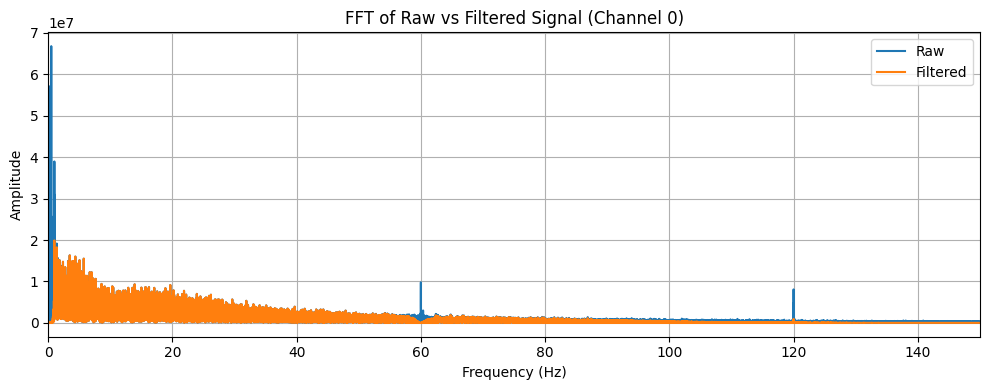

In [ ]:
from scipy.fft import fft, fftfreq

raw_ecog = data['train_ecog'][0][0]
raw_ch = raw_ecog[:, 0]
filtered_ch = filter_ecog(raw_ch)

# FFT
raw_fft = fft(raw_ch)
filt_fft = fft(filtered_ch)

from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

fs = 1000  # Hz
N = len(raw_ch)  # total samples
timestep = 1 / fs

# Pick one channel
raw_ch = raw_ecog[:, 0]
filtered_ch = filter_ecog(raw_ch,order=5)

# FFT
raw_fft = fft(raw_ch)
filt_fft = fft(filtered_ch)
freqs = fftfreq(N, timestep)

# Plot positive frequencies only
plt.figure(figsize=(10, 4))
plt.plot(freqs[:N//2], np.abs(raw_fft[:N//2]), label='Raw')
plt.plot(freqs[:N//2], np.abs(filt_fft[:N//2]), label='Filtered')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Raw vs Filtered Signal (Channel 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,150)
#plt.ylim(0, 1e7/5)
plt.show()


Initial FFT analysis of butterworth alone showed there were 60Hz peak that was removed with notch filter. Band pass shown to worked especially near the 0-5Hz range where low frequency drift occurs. Also low amplitude shown after 100Hz. Though raw signal also has los amplitude there. But 120Hz peak in raw is not in filtered so assuming bandpass works.

In [ ]:
#Get windows
def get_windows(filtered_ecog, fs = 1000, winLen = 0.1, winShift = 0.05):
  '''
  Function to get the windows in the filtered signal

  Inputs
  filtered_ecog = numpy array of filtered ecog
  fs = sampling frequency. 1000Hz
  winLen = window length in seconds. 0.1
  winShift = window shift in seconds. 0.05

  Outputs
  window_data = list of numpy arrays of windows
  '''
  import numpy as np

  #initialize windows
  window_data = []

  #get number of windows
  xLen = len(filtered_ecog) #get length of signal
  sam_WL = int(winLen * fs) #convert windoe length to number of samples
  sam_WS = int(winShift * fs) #convert window displacement to number of samples
  NumWins = int((xLen - sam_WL) / sam_WS) + 1 #return number of full windows

  for i in range(NumWins):
    #get window
    filtered_window = filtered_ecog[i*sam_WS:(i*sam_WS)+sam_WL,:]
    window_data.append(filtered_window) #append to list

  #np vstack to make windows a 3D array
  window_data = np.stack(window_data)


  return window_data

Will experiment with different window lengths and shifts to decide best approach best on training data

In [ ]:
def calc_features(windows, fs = 1000):
  '''
  Function to calculate features from windows

  Inputs
  windows = numpy array of windows
  fs = sampling frequency. 1000Hz

  Outputs
  features = numpy array of features
  '''
  #import
  import numpy as np
  from scipy.signal import welch

  #Time domain features
  # RMS: sqrt(mean(x^2))
  rms = np.sqrt(np.mean(windows ** 2, axis=1))
  # Log-variance 1e-8 adds a small value to prevent log(0)
  logvar = np.log(np.var(windows, axis=1) + 1e-8)
  # Slope: sum of absolute differences
  slope = np.sum(np.abs(np.diff(windows, axis=1)), axis=1)

  #Frequency domain features
  NumWins, samples, channels = windows.shape #get information about windows
  #Initialize arrays to store values
  beta = np.zeros((NumWins, channels)) #beta power for movement planning
  low_gamma = np.zeros((NumWins, channels)) #low gamma for execution phase activation
  high_gamma = np.zeros((NumWins, channels)) #high gamma for fine motor controls

  # Loop over channels only (welch is vectorized over windows)
  for ch in range(channels):
      f, Pxx = welch(windows[:, :, ch], fs=fs, nperseg=samples, axis=1)  # Pxx: (N, F)

      # Frequency masks
      beta[:, ch] = Pxx[:, (f >= 15) & (f < 30)].mean(axis=1)
      low_gamma[:, ch] = Pxx[:, (f >= 30) & (f < 50)].mean(axis=1)
      high_gamma[:, ch] = Pxx[:, (f >= 70) & (f < 100)].mean(axis=1)


  # Stack all features along last axis → shape: (num_windows, channels, 3)
  tf_features = np.stack([rms, logvar, slope, beta, low_gamma, high_gamma], axis=-1)

  tf_features = tf_features.reshape(windows.shape[0], -1)

  myfeats = np.concatenate([slope, low_gamma, high_gamma], axis=1)
  myfeats = myfeats.reshape(windows.shape[0], -1)


  corr_features = []
  for w in windows:
    w_norm = (w - w.mean(axis=0)) / (w.std(axis=0) + 1e-8)            # z-score normalization
    corr_matrix = np.corrcoef(w_norm.T)                               # (channels x channels)
    upper_tri = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]  # Flatten upper triangle
    corr_features.append(upper_tri)

  corr_features = np.array(corr_features)  # shape: (NumWins, num_pairs)

  features = np.concatenate([tf_features, corr_features], axis=1)
  return myfeats

In [ ]:
raw_ecog = data['train_ecog'][0][0] #for first subject
filtered_ecog = filter_ecog(raw_ecog) #filtered signal
windows = get_windows(filtered_ecog) #separate into windows
features = calc_features(windows) # get features


In [ ]:
print(raw_ecog.shape)
print(filtered_ecog.shape)
print(windows.shape)
print(features.shape)

(300000, 62)
(300000, 62)
(5999, 100, 62)
(5999, 186)


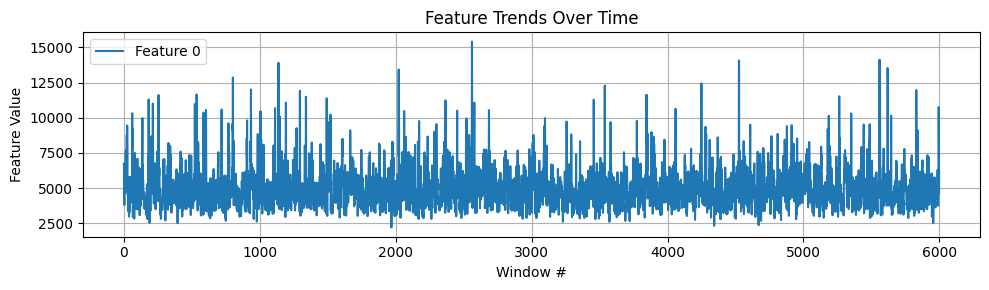

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(features[:, 0 * 6 + 0], label="Feature 0")  # e.g., RMS of channel 0
#plt.plot(features[:, 1 * 6 + 1], label="Feature 1")  # e.g., logvar of channel 0
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

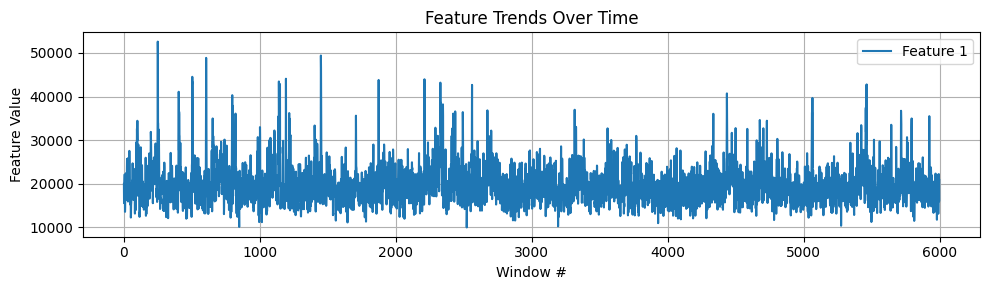

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(features[:, 1 * 6 + 1], label="Feature 1")  # e.g., logvar of channel 1
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

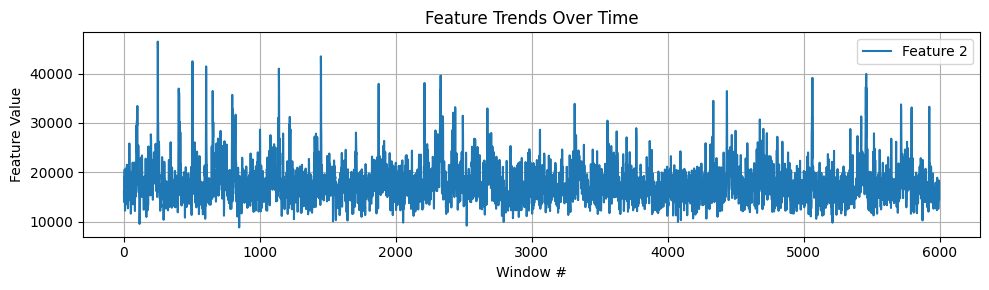

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(features[:, 2 * 6 + 2], label="Feature 2")  # e.g., slope of channel 2
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

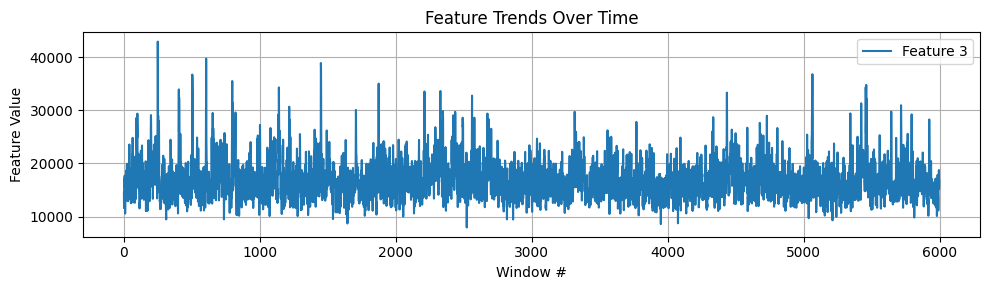

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(features[:, 3 * 6 + 3], label="Feature 3")  # e.g., beta of channel 3
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

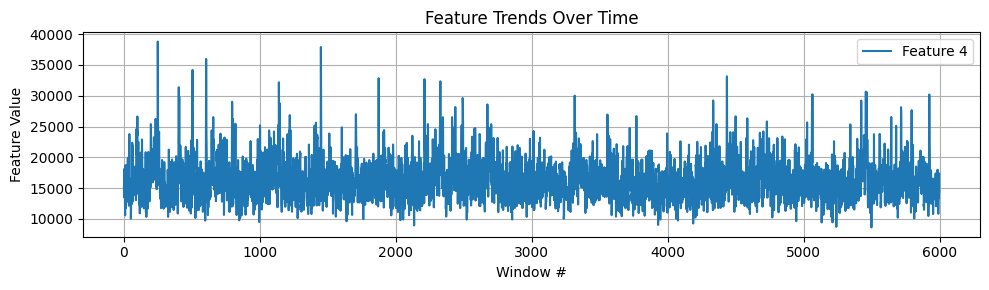

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(features[:, 4 * 6 + 4], label="Feature 4")  # e.g., low gamma of channel 4
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

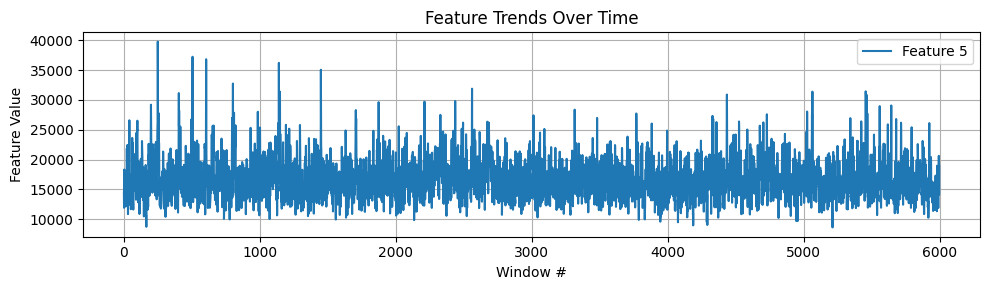

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(features[:, 5 * 6 + 5], label="Feature 5")  # e.g., high gamma of channel 5
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
raw_dg = data['train_dg'][0][0] #for first subject

In [ ]:
raw_dg.shape

(300000, 5)

In [ ]:
def downsample_dg(raw_dg, features, fs=1000, lag=0.037, WinLen=0.1, WinShift=0.05):
  '''
  Function to downsample dg

  Inputs
  raw_dg = numpy array of raw dg
  features = numpy array of features
  fs = sampling frequency. 1000Hz
  lag = lag in seconds. 0.037
  WinLen = window length in seconds. 0.1
  winShift = window shift in seconds. 0.05

  Outputs
  down_dg = numpy array of downsampled dg
  '''
  NumWins = features.shape[0]
  SamWD = int(WinLen * fs) #convert window length to number of samples
  SamWS = int(WinShift * fs) #convert window displacement to number of samples
  centers = np.arange(NumWins) * SamWS + SamWD // 2 #get center of each window

  #add lag from paper
  lag_samples = int(lag * fs)
  centers = centers + lag_samples

  #get downsampled dataglove
  down_dg = raw_dg[centers]

  return down_dg




In [ ]:
raw_dg = data['train_dg'][0][0] #for first subject
down_dg = downsample_dg(raw_dg, features)

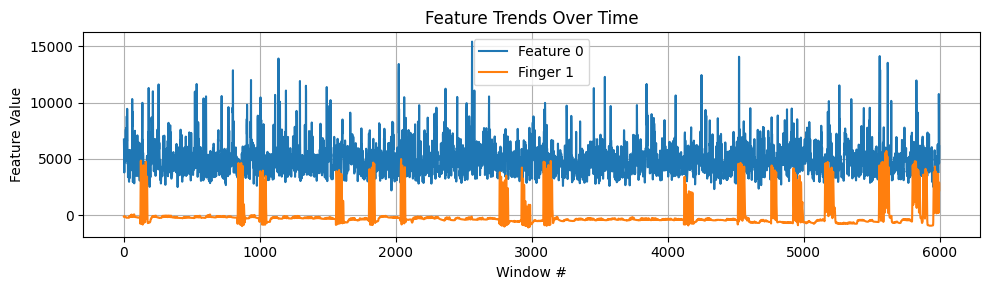

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(features[:, 0 * 6 + 0], label="Feature 0")  # e.g., RMS of channel 0
plt.plot(down_dg[:, 0]*1000, label='Finger 1')  # e.g., dataglove
plt.title("Feature Trends Over Time")
plt.xlabel("Window #")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

for feat in range(3):
  X = features[:, [i * 3 + feat for i in range(62)]]  # just Feature 0 across all channels
  for dig in range(5):
    y = down_dg[:, dig]     # Finger 1

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"Finger {dig}, Feature {feat}: R² {r2_score(y, y_pred)}")




Finger 0, Feature 0: R² 0.04507359955743784
Finger 1, Feature 0: R² 0.22797679744585808
Finger 2, Feature 0: R² 0.03287665747179991
Finger 3, Feature 0: R² 0.06822261259006279
Finger 4, Feature 0: R² 0.03680303435135335
Finger 0, Feature 1: R² 0.04657209579655486
Finger 1, Feature 1: R² 0.23085842715212912
Finger 2, Feature 1: R² 0.030369110225423435
Finger 3, Feature 1: R² 0.059616396384882586
Finger 4, Feature 1: R² 0.027110531701526108
Finger 0, Feature 2: R² 0.0334189635045693
Finger 1, Feature 2: R² 0.23171209573559703
Finger 2, Feature 2: R² 0.028098164460147568
Finger 3, Feature 2: R² 0.061059035104528814
Finger 4, Feature 2: R² 0.031160609774754322


(5999, 384)

Best features appear to be high gamma and slope. Test with those two

In [ ]:
selected_features = [0, 1, 2, 3, 4, 5, 6]  # slope and high gamma
idxs = [i * 6 + f for i in range(62) for f in selected_features]
X = features[:]
models1 = []

for dig in range(5):
  y = down_dg[:, dig]     # Finger 1

  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)
  models1.append(model)

  print(f"Finger {dig}: R² {r2_score(y, y_pred)}")


Finger 0: R² 0.12390204425450113
Finger 1: R² 0.266608609300631
Finger 2: R² 0.061559872935737725
Finger 3: R² 0.14432365408999748
Finger 4: R² 0.08650465318848499


In [ ]:
import pickle

sub1models = {
    "finger_0": models1[0],
    "finger_1": models1[1],
    "finger_2": models1[2],
    "finger_3": models1[3],
    "finger_4": models1[4]
}

with open("Sub1mods.pkl", "wb") as f:
    pickle.dump(sub1models, f)

In [ ]:
#for subject2
raw_ecog2 = data['train_ecog'][1][0] #for second subject
filtered_ecog2 = filter_ecog(raw_ecog2) #filtered signal
windows2 = get_windows(filtered_ecog2) #separate into windows
features2 = calc_features(windows2) # get features
raw_dg2 = data['train_dg'][1][0] #for first subject
down_dg2 = downsample_dg(raw_dg2, features2)

In [ ]:
X = features2[:]
models2 = []

for dig in range(5):
  y = down_dg2[:, dig]     # Finger 1

  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)
  models2.append(model)

  print(f"Finger {dig}: R² {r2_score(y, y_pred)}")

Finger 0: R² 0.10074260403284951
Finger 1: R² 0.05972622905682312
Finger 2: R² 0.051624487584127854
Finger 3: R² 0.0787253821135846
Finger 4: R² 0.04271257047118571


In [ ]:
import pickle

sub2models = {
    "finger_0": models2[0],
    "finger_1": models2[1],
    "finger_2": models2[2],
    "finger_3": models2[3],
    "finger_4": models2[4]
}

with open("Sub2mods.pkl", "wb") as f:
    pickle.dump(sub2models, f)

In [ ]:
#subject 3
raw_ecog3 = data['train_ecog'][2][0] #for second subject
filtered_ecog3 = filter_ecog(raw_ecog3) #filtered signal
windows3 = get_windows(filtered_ecog3) #separate into windows
features3 = calc_features(windows3) # get features
raw_dg3 = data['train_dg'][2][0] #for first subject
down_dg3 = downsample_dg(raw_dg3, features3)

In [ ]:
X = features3[:]
models3 = []

for dig in range(5):
  y = down_dg3[:, dig]     # Finger 1

  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)
  models3.append(model)

  print(f"Finger {dig}: R² {r2_score(y, y_pred)}")

Finger 0: R² 0.15943873067839465
Finger 1: R² 0.12404372689219578
Finger 2: R² 0.12330173202669381
Finger 3: R² 0.137775817036368
Finger 4: R² 0.1250004173644521


In [ ]:
import pickle

sub3models = {
    "finger_0": models3[0],
    "finger_1": models3[1],
    "finger_2": models3[2],
    "finger_3": models3[3],
    "finger_4": models3[4]
}

with open("Sub3mods.pkl", "wb") as f:
    pickle.dump(sub3models, f)

In [ ]:
#get a model train on all subjects